#Image Classification Model Using Fast AI 

In [1]:
#This is to ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
!pip install fastai
from fastai.vision import *
from fastai.metrics import error_rate

     |████████████████████████████████| 245kB 7.2MB/s eta 0:00:01
     |████████████████████████████████| 10.6MB 62.2MB/s eta 0:00:01
     |████████████████████████████████| 122kB 61.7MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 36.8MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 61.3MB/s eta 0:00:01
     |████████████████████████████████| 194kB 57.0MB/s eta 0:00:01
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-cp36-none-any.whl size=19192 sha256=2a56a02a88454e9301654682e387851dca72218e301753effde4c43cd6dd5eba
  Stored in directory: /home/azureuser/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
Successfully built nvidia-ml-py3


In [3]:
# Connect to an existing Azure ML Workshop in order to use Azure ML Datasets and Runs Logging into AML
import azureml 
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.get_details())

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code AH3X9LUG9 to authenticate.
Interactive authentication successfully completed.
{'id': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/PipelinesUsabilityStudy/providers/Microsoft.MachineLearningServices/workspaces/shwinneworkshop', 'name': 'shwinneworkshop', 'location': 'eastus2', 'type': 'Microsoft.MachineLearningServices/workspaces', 'tags': {}, 'sku': 'Enterprise', 'workspaceid': '2c99da6f-e7fc-4070-b1f7-204807455abf', 'description': '', 'friendlyName': '', 'creationTime': '2020-01-13T20:47:53.0433365+00:00', 'containerRegistry': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourceGroups/PipelinesUsabilityStudy/providers/Microsoft.ContainerRegistry/registries/shwinneworks933cbd9b', 'keyVault': '/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusa

#Data 

We are going to use the Food 101 dataset (https://www.kaggle.com/kmader/food41#1028787.jpg ) which features 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. For the purpose of this notebook, we will be classifying amongst 5 different food categories (applie pie, waffles, padthai, bread pudding and ramen) and only using 200 images per food category. We will use a training set of 160 images and a validation set of 60 images for each class of food. 

The images are located in the 'data' folder. Each subfolder represents the class of food that you will classify. To register this data as an AML dataset, please read the dataset.md file located in this folder. 

In [4]:
from azureml.core import Dataset
#Get and download food images from the File Datasets from your workspace
#Create directory and choose an appropriate folder name for your labeled images


apple_pie_dataset = Dataset.get_by_name(ws, name='apple-pie')
apple_pie_dataset.download(target_path='./data/apple-pie', overwrite=False)

waffles_dataset = Dataset.get_by_name(ws, name='waffles')
waffles_dataset.download(target_path='./data/waffles', overwrite=False)

padthai_dataset = Dataset.get_by_name(ws, name='pad-thai')
padthai_dataset.download(target_path='./data/padthai', overwrite=False)

breadpudding_dataset = Dataset.get_by_name(ws, name='bread-pudding')
breadpudding_dataset.download(target_path='./data/breadpudding', overwrite=False)

ramen_dataset = Dataset.get_by_name(ws, name='ramen')
ramen_dataset.download(target_path='./data/ramen', overwrite=False)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2926541.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2947802.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2950172.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2953484.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2955110.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2955328.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2966384.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2968505.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2972875.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-vm/code/FastAI/fastai/data/ramen/2977

In [5]:
import pathlib
from pathlib import Path

#directory to images 
path = Path('data')
path.ls()

[PosixPath('data/apple-pie'),
 PosixPath('data/breadpudding'),
 PosixPath('data/padthai'),
 PosixPath('data/ramen'),
 PosixPath('data/waffles')]

In [6]:
#class for each category to classify

classes = ['apple-pie','breadpudding','padthai', 'ramen', 'waffles']

In [7]:
#remove any images that cannot be opened 

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=2200)

apple-pie


breadpudding


padthai


ramen


waffles


# View Data

ImageDataBunch returns a data bunch object which is needed for modeling in fast AI. This contains the images and labels for the training, validation and/or test datasets. 

We want to ensure that all images are the same shape and size for better GPU performance. We will use size = 224 to ensure that all the images are of 224x224 square size.

If the data is not normalized, we can have difficulty training a model. We want the red, green and blue channels of the images to have a mean of 0 and standard deviation of 1. 

The get_transforms function makes the size of the image 224 x 224 by doing a combination of things like center cropping and resizing. 

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

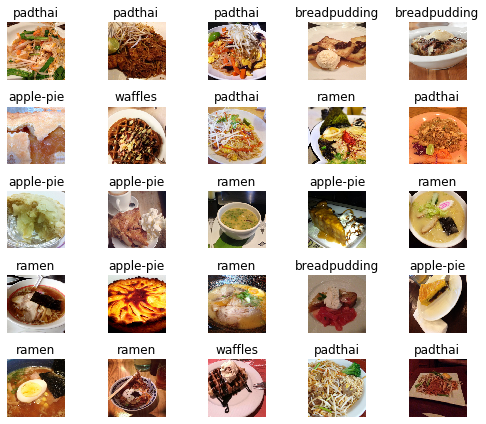

In [9]:
#let's take a look at our delicious food! Yummmyyy....

data.show_batch(rows=5, figsize=(7,6))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['apple-pie', 'breadpudding', 'padthai', 'ramen', 'waffles'], 5, 800, 200)

# Training 

Convolutional Neural Networks (http://cs231n.github.io/convolutional-networks/) are very similar to ordinary neural networks but the assumption is that the inputs are images- they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. Activation functions are applied to each node to capture non linearities in the data.

We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. We are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 5 outputs).

In [11]:
#create your model 

learn = cnn_learner(data, models.resnet34, metrics=accuracy)
print(type(learn))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/azureuser/.cache/torch/checkpoints/resnet34-333f7ec4.pth



<class 'fastai.basic_train.Learner'>


In [12]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.693333,0.803194,0.795000,00:23
1,1.207299,0.757157,0.780000,00:16


In [ ]:
# save model and export model

learn.path = Path(".") 
learn.export()
path = learn.path
path

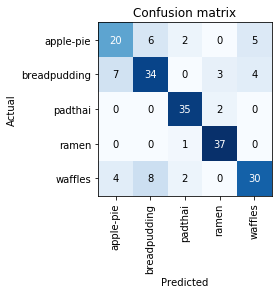

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
from azureml.core import Experiment, Run

#create new aml experiment 
experiment = Experiment(ws, 'fastai-food-classification')

In [ ]:
%%writefile train.py

from fastai.vision import (ImageDataBunch, get_transforms, cnn_learner, models, imagenet_stats, accuracy)
#from fastai.metrics import error_rate
from pathlib import Path 
from azureml.core.run import Run 
import numpy as np

# get the Azure ML run object
run = Run.get_context()

# get images
path = Path('data')
np.random.seed(2)
data = ImageDataBunch.from_folder(path,
                                       train=".",
                                       valid_pct=0.2,
                                       ds_tfms=get_transforms(),
                                       size=224).normalize(imagenet_stats)

# build estimator based on ResNet 34
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2)

# do test time augmentation and get accuracy
acc = accuracy(*learn.TTA())


# log the accuracy to run
run.log('Accuracy', np.float(acc))
print("Accuracy: ", np.float(acc))

# Save the model to the root. Note: this is not registering model
learn.path = Path(".")
learn.export()
path = learn.path
path

In [ ]:
from azureml.core.environment import CondaDependencies
from azureml.core import Environment
from azureml.core import ScriptRunConfig

azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 5000000000

#Instead of managing the setup of the environment yourself, you can ask the system to build a new conda environment for you. 
#The environment is built once, and will be reused in subsequent executions as long as the conda dependencies remain unchanged.

myenv = Environment(name="myenv")
conda_dep = CondaDependencies()
conda_dep.add_pip_package("fastai")
conda_dep.add_pip_package("ipykernel")
myenv.python.conda_dependencies=conda_dep

myenv.python.user_managed_dependencies = False

#To submit a run, create a run configuration that combines the script file and environment, and pass it to Experiment.submit. 
#In this example, the script is submitted to local computer, but you can specify other compute targets such as remote clusters as well.

runconfig = ScriptRunConfig(source_directory=".", script="train.py")
runconfig.run_config.target = "local"
runconfig.run_config.environment = myenv
run = experiment.submit(config=runconfig)

run.wait_for_completion(show_output=True)

In [ ]:
from azureml.widgets import RunDetails 
RunDetails(run).show()

In [ ]:
#To run on a remote cluster, please run this cell.

# Define remote compute target to use. Further docs on Remote Compute Target: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-remote

# Choose a name for your cluster.
amlcompute_cluster_name = "gpu-cluster"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets

if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
     found = True
     print('Found existing training cluster.')
     # Get existing cluster
     # Method 1:
     aml_remote_compute = cts[amlcompute_cluster_name]
     # Method 2:
     # aml_remote_compute = ComputeTarget(ws, amlcompute_cluster_name)
    
if not found:
     print('Creating a new training cluster...')
     provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D13_V2", # for GPU, use "STANDARD_NC12"
                                                                 #vm_priority = 'lowpriority', # optional
                                                                 max_nodes = 20)
     # Create the cluster.
     aml_remote_compute = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.

aml_remote_compute.wait_for_completion(show_output = True, min_node_count = 0, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

In [ ]:
#If you would like to run remotely, please run this cell and the following two cells 

#Next, we construct an `azureml.train.dnn.PyTorch` estimator object
#The PyTorch estimator provides a simple way of launching a PyTorch training job on a compute target. 
#We'll submit the train.py file using the `entry_script` parameter and use the gpu-cluster we created above as our `compute target`
#Since fastai v1 is built on top of PyTorch 1.0, we can use the `framework_version` parameter to specify our PyTorch version, and the estimator will automatically retrieve a Docker image that has PyTorch 1.0 and its dependencies installed.
#Finally, on top of our PyTorch base image, we'll add the fastai v1 and pillow packages using the `pip_packages` parameter. The pillow package is necessary for image processing, and we'll pin to versions below 7.0.0 since those are known to be compatible with PyTorch 1.0's torchvision package

from azureml.train.dnn import PyTorch

estimator = PyTorch(source_directory=".",
                            compute_target="gpu-cluster",
                            entry_script='train.py',
                            framework_version='1.0',
                            pip_packages=['fastai', 'pillow<7'])

In [ ]:
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 500000000000
run = experiment.submit(estimator)

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

In [ ]:
# Save the model to the root. Note: this is not registering model
learn.path = Path(".")
learn.export()
path = learn.path
path

In [16]:
#Register the model
from azureml.core.model import Model

# register the model1
model = Model.register(model_path = "export.pkl", # this points to a local file
                       model_name = "food_classification_model2", # this is the name the model is registered as
                       tags = {'food': "Yummmm :)"},
                       description = "Model predicting types of food",
                       workspace = ws)

print(model.name, model.description, model.version)

Registering model food_classification_model2
food_classification_model2 Model predicting types of food 22


#Prepare to deploy


To deploy the model, you need the following items:

1) An entry script, this script accepts requests, scores the requests by using the model, and returns the results.
2) Dependencies, like helper scripts or Python/Conda packages required to run the entry script or model.
3) The deployment configuration for the compute target that hosts the deployed model. This configuration describes things like memory and CPU requirements needed to run the model.

Define your entry script and dependencies

We will first write the entry script as shown below. Note a few points in the entry script.

The script contains two functions that load and run the model:

init(): Typically, this function loads the model into a global object. This function is run only once, when the Docker container for your web service is started.

When you register a model, you provide a model name that's used for managing the model in the registry. You use this name with the Model.get_model_path() method to retrieve the path of the model file or files on the local file system. If you register a folder or a collection of files, this API returns the path of the directory that contains those files.

run(input_data): This function uses the model to predict a value based on the input data. Inputs and outputs of the run typically use JSON for serialization and deserialization. You can also work with raw binary data. You can transform the data before sending it to the model or before returning it to the client.

In [28]:
%%writefile score.py

import os
import json
from azureml.core.model import Model
from azureml.core import Workspace
import fastai 
from fastai.vision import *
from fastai.metrics import accuracy 
from fastai.metrics import error_rate
import urllib.request


global food_classification_model


def download_jpg(url):
    file_path = "./breadpudding.jpg"
    local_filename, header = urllib.request.urlretrieve(url, file_path)    
    return local_filename
  

def init():   
    # The AZUREML_MODEL_DIR environment variable indicates a directory containing the model file you registered.  
    #this init works 
    model_path=os.getenv('AZUREML_MODEL_DIR')     
    filename='export.pkl'
    food_classification_model = load_learner(path=model_path, file=filename)   
    classes = food_classification_model.data.classes
    print(classes)


def run(request):   
    candidate_url = json.loads(request)["url"]   
    file_path = download_jpg(candidate_url)
    img = open_image(file_path)
    prediction = food_classification_model.predict(img)
    index = 0
    pred = str(prediction[index])
    print(pred)
    return pred


# if __name__ == "__main__":
#     init()  
#     request = { "url": "https://i.imgur.com/TqlREOJ.jpg"}
#     run(request)
#     print("main")

Overwriting score.py


It returns a tuple of three things: the object predicted (with the class in this instance), the underlying data (here the corresponding index) and the raw probabilities. You can also do inference on a larger set of data by adding a test set. This is done by passing an ItemList to load_learner.

learn = load_learner(mnist, test=ImageList.from_folder(mnist/'test'))
https://docs.fast.ai/tutorial.inference.html

Define dependencies
The following YAML is the Conda dependencies file we will use for inference. If you want to use automatic schema generation, your entry script must import the inference-schema packages.

In [18]:
%%writefile myenv.yml

name: project_environment
dependencies:
- python=3.6.9

- pip:
  - fastai
  - torch
  - torchvision  
  - azureml-defaults
  - azureml-core
  - matplotlib==3.1.2
- numpy==1.16.2
- Pillow==6.2.0
- pandas==0.23.4



Writing myenv.yml


In [19]:
from azureml.core import Environment

# Instantiate environment
myenv = Environment.from_conda_specification(name = "myenv",
                                             file_path = "myenv.yml")

Define your inference configuration. The inference configuration describes how to configure the model to make predictions. This configuration isn't part of your entry script. It references your entry script and is used to locate all the resources required by the deployment. It's used later, when you deploy the model.


In [20]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='score.py', environment=myenv)

Define your deployment configuration Before deploying your model, you must define the deployment configuration. The deployment configuration is specific to the compute target that will host the web service. The deployment configuration isn't part of your entry script. It's used to define the characteristics of the compute target that will host the model and entry script.

In [21]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags = {'task': "image-classification"}, 
                                               description='A model to predict types of food')

Deployment uses the inference configuration deployment configuration to deploy the models. The deployment process is similar regardless of the compute target

In [29]:
service = Model.deploy(ws, name='image-classification-fastai0', models=[model], inference_config= inference_config, deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Running......................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [30]:
service.get_logs()

"2020-03-18T12:30:41,430005069+00:00 - iot-server/run \n2020-03-18T12:30:41,428889467+00:00 - gunicorn/run \n2020-03-18T12:30:41,437834982+00:00 - nginx/run \n2020-03-18T12:30:41,456410413+00:00 - rsyslog/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2020-03-18T12:30:41,724385659+00:00 - iot-server/finish 1 0\n2020-03-18T12:30:41,729901568+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (13)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 40\nInitialized PySpark session.\ngenerated new fontManager\nInitializing logger\nStarting up app insights client\nStarting up request id generator\nStarting up app insight hooks\nInvoking user's init function\n/azureml-envs/azureml_22475f04781b244b833b0f9e63ab9cf3/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torchvision.models.resnet.BasicBlock' has changed. you

In [31]:
import json
  
request = json.dumps({"url": "https://i.imgur.com/TqlREOJ.jpg"})
prediction = service.run(request)
print(prediction)

ERROR - Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.
Response Code: 502
Headers: {'Connection': 'keep-alive', 'Content-Length': '47', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 18 Mar 2020 12:38:21 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': 'bd35f02f-3f94-4f48-8527-296d4f8e3e18', 'X-Ms-Run-Function-Failed': 'True'}
Content: b"name 'food_classification_model' is not defined"



WebserviceException: WebserviceException:
	Message: Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.
Response Code: 502
Headers: {'Connection': 'keep-alive', 'Content-Length': '47', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 18 Mar 2020 12:38:21 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': 'bd35f02f-3f94-4f48-8527-296d4f8e3e18', 'X-Ms-Run-Function-Failed': 'True'}
Content: b"name 'food_classification_model' is not defined"
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Received bad response from service. More information can be found by calling `.get_logs()` on the webservice object.\nResponse Code: 502\nHeaders: {'Connection': 'keep-alive', 'Content-Length': '47', 'Content-Type': 'text/html; charset=utf-8', 'Date': 'Wed, 18 Mar 2020 12:38:21 GMT', 'Server': 'nginx/1.10.3 (Ubuntu)', 'X-Ms-Request-Id': 'bd35f02f-3f94-4f48-8527-296d4f8e3e18', 'X-Ms-Run-Function-Failed': 'True'}\nContent: b\"name 'food_classification_model' is not defined\""
    }
}

In [32]:
service.get_logs()

'2020-03-18T12:30:41,430005069+00:00 - iot-server/run \n2020-03-18T12:30:41,428889467+00:00 - gunicorn/run \n2020-03-18T12:30:41,437834982+00:00 - nginx/run \n2020-03-18T12:30:41,456410413+00:00 - rsyslog/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2020-03-18T12:30:41,724385659+00:00 - iot-server/finish 1 0\n2020-03-18T12:30:41,729901568+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (13)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 40\nInitialized PySpark session.\ngenerated new fontManager\nInitializing logger\nStarting up app insights client\nStarting up request id generator\nStarting up app insight hooks\nInvoking user\'s init function\n/azureml-envs/azureml_22475f04781b244b833b0f9e63ab9cf3/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class \'torchvision.models.resnet.BasicBlock\' has changed. 

apple-pie


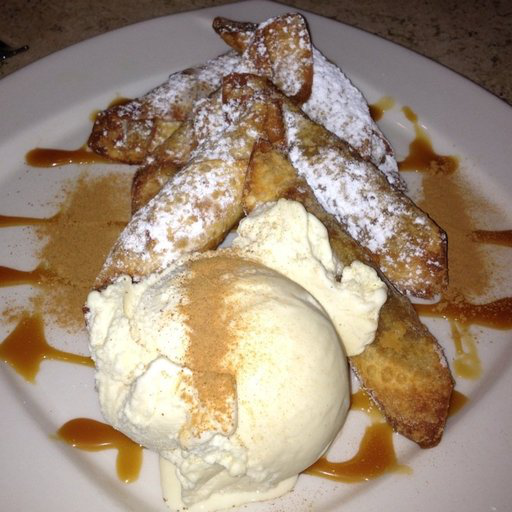

In [36]:
img = open_image('data/apple-pie/3068872.jpg')
prediction = learn.predict(img)
print(prediction[0])
img
